In [3]:
DATA_DIR = 'C:/Users/gybj0/Desktop/data'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import os

train = pd.read_csv(os.path.join(DATA_DIR, 'optiver_volatility', 'train.csv'))
stock_ids = set(train['stock_id'])

def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, 'optiver_volatility', directory, f'stock_id={stock_id}'))

def load_book(stock_id: int, type:  str) -> pd.DataFrame:
    return load_stock_data(stock_id, f'book_{type}.parquet')

def load_trade(stock_id: int, type: str) -> pd.DataFrame:
    return load_stock_data(stock_id, f'trade_{type}.parquet')

def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def log_return(series: np.ndarray):
    return np.log(series).diff()

def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)

def make_book_feature(stock_id: int, type: str) -> pd.DataFrame:
    book = load_book(stock_id, type)

    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return)

    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))

    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    book = book.fillna(method = 'ffill').dropna()
    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = ['_'.join(col) for col in agg.columns]
    agg['stock_id'] = stock_id   
    return book

def make_trade_feature(stock_id: int, type: str) -> pd.DataFrame:
    trade = load_trade(stock_id, type)
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return)

    features = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':['count'],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    trade = trade.fillna(method = 'ffill').dropna()
    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = ['_'.join(col) for col in agg.columns]
    agg['stock_id'] = stock_id
    return trade

def make_features(stock_ids, type):
    from joblib import Parallel, delayed
    book = Parallel(n_jobs = -1)(delayed(make_book_feature)(i, type) for i in stock_ids)
    books = pd.concat(book)
    trade = Parallel(n_jobs = -1)(delayed(make_trade_feature)(i, type) for i in stock_ids)
    trades = pd.concat(trade)
    features = pd.merge(books, trades, how = 'inner', on = ['stock_id','time_id_'])
    return features


In [2]:
make_book_feature(1, 'train')

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,...,log_return_ask1,log_return_ask2,log_return_bid1,log_return_bid2,wap_balance,price_spread,bid_spread,ask_spread,total_volume,volume_imbalance
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100,...,0.000131,0.000131,0.000000,0.000000,1.333381e-04,0.000918,0.000066,-0.000066,211,109
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125,...,-0.000262,-0.000262,0.000000,-0.000066,1.420883e-05,0.000655,0.000131,-0.000066,176,124
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36,...,0.000131,0.000131,0.000000,0.000066,7.318126e-06,0.000786,0.000066,-0.000066,312,190
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25,...,-0.000065,-0.000065,0.000000,-0.000066,3.278255e-05,0.000721,0.000131,-0.000066,250,0
5,5,5,1.000754,1.001542,1.000623,1.001673,100,25,25,60,...,0.000065,0.000131,0.000000,0.000000,4.522800e-04,0.000786,0.000131,-0.000131,210,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507527,32767,588,0.998911,0.999109,0.998812,0.999208,126,42,101,100,...,0.000000,-0.000198,-0.000099,-0.000099,4.845739e-05,0.000198,0.000099,-0.000099,369,85
1507528,32767,589,0.998911,0.999109,0.998812,0.999208,126,126,101,200,...,0.000000,0.000000,0.000000,0.000000,6.506590e-05,0.000198,0.000099,-0.000099,553,99
1507529,32767,591,0.998911,0.999109,0.998812,0.999208,126,226,101,200,...,0.000000,0.000000,0.000000,0.000000,3.695689e-05,0.000198,0.000099,-0.000099,653,199
1507530,32767,592,0.998911,0.999109,0.998812,0.999208,226,225,101,100,...,0.000000,0.000000,0.000000,0.000000,7.950777e-07,0.000198,0.000099,-0.000099,652,2


<AxesSubplot: >

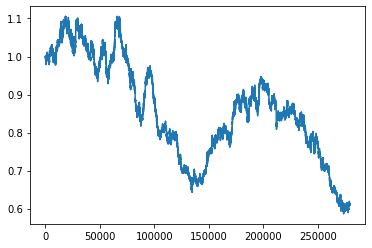

In [10]:
(make_trade_feature(3, 'train').log_return+1).cumprod().plot()

In [84]:
train_features = make_features(stock_ids, 'train')

test = pd.read_csv(os.path.join(DATA_DIR, 'optiver_volatility','test.csv'))
test_ids = set(test.stock_id)

test_features = make_features(test_ids, 'test')


In [113]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

from sklearn.linear_model import Lasso


trains=pd.merge(train_features, train, left_on = ['time_id_','stock_id'], right_on = ['time_id','stock_id'], how = 'inner')

drop_col = ['target','time_id','time_id_','stock_id']
train_X = trains[trains.time_id_ < 32767 * 0.8].loc[:, ~trains.columns.isin(drop_col)]
train_y = trains[trains.time_id_ < 32767 * 0.8].target

test_X = trains[trains.time_id_ > 32767 * 0.8].loc[:, ~trains.columns.isin(drop_col)]
test_y = trains[trains.time_id_ > 32767 * 0.8].target

model = Lasso()
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
print(rmspe(test_y, y_pred))

from sklearn.ensemble import RandomForestRegressor

random = RandomForestRegressor()
random.fit(train_X, train_y)
y_pred = random.predict(test_X)
print(rmspe(test_y, y_pred))


1.130823988098436
0.0006416819842793221


In [114]:
model.coef_

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -3.35252217e-11,
        0.00000000e+00,  0.00000000e+00,  3.77211011e-11,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.16615558e-09,
        0.00000000e+00, -

In [115]:
trains.to_csv('train.csv')